## This script fits simple cross validated SVM using single fit and alpy

## It should be straightforward to go from this script to running experiments on any fingerprint/compound pair

In [87]:
% load_ext autoreload
% autoreload 2
import matplotlib.pylab as plt
% matplotlib inline
import sys
import seaborn
sys.path.insert(0, "../mlls2015")
sys.path.insert(0, "..")
import training_data
from training_data.datasets import CVBaseChemDataset
import bunch
import numpy as np
from bunch import Bunch
import os
import logging
from experiments.utils import wac_score
from misc.utils import config_log_to_file

import copy

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import alpy_addons
from alpy_addons.active import ActiveLearner
from alpy.datasets.generate import get_2d_gaussians
from alpy_addons.monitors import *
from alpy.oracle import SimulatedOracle
from alpy.strategy import UncertaintySampling, PassiveStrategy
from alpy.utils import mask_unknowns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
opts = Bunch({"C_min": -6, 
              "C_max": 3, 
              "n_folds": 5, 
              "preprocess": "max_abs", 
              "fold": 2, 
              "compound": "beta2", 
              "representation": "MACCS", 
              "jaccard": 0, 
              "rng": 777, 
              "name": "test_svm_al",
              "batch_size": 30,
              "output_dir": "/Users/kudkudak/code/mlls2015/"})

In [89]:
config_log_to_file(os.path.join(opts.output_dir, opts.name + ".log"), clear_log_file=True)
logger = logging.getLogger("fit_svm")
logger.info(opts.__dict__)
logger.info(opts.name)

INFO:fit_svm:{}
INFO:fit_svm:test_svm_al


In [90]:
data = CVBaseChemDataset(compound=opts.compound, representation=opts.representation, n_folds=opts.n_folds, rng=opts.rng,
                       preprocess=opts.preprocess)
(X_train, y_train), (X_valid, y_valid) = data.get_data(fold=opts.fold)
if opts.jaccard:
    K_train, K_valid = calculate_jaccard_kernel(data=data, fold=opts.fold)

In [91]:
class EstimatorMonitor(BaseMonitor):
    def __init__(self):
        super(EstimatorMonitor, self).__init__(name="EstimatorMonitor", short_name="est_mon")

    def __call__(self, estimator, X, labels):
        if not isinstance(estimator, BaseEstimator):
            raise TypeError("Got bad estimator: {}".format(type(estimator)))

        return copy.copy(estimator)

y_train_masked = mask_unknowns(y_train, np.random.choice(X_train.shape[0], size=X_train.shape[0] - 10, replace=False))

In [92]:
# TODO: add TP/FN/TN/FP recording
monitors = []

monitors.append(MetricMonitor(name="wac_score",
                        short_name="wac",
                        function=wac_score,
                        ids="all",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_labeked",
                        short_name="wac_labeled",
                        function=wac_score,
                        ids="known",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_unlabeled",
                        short_name="wac_unlabeled",
                        function=wac_score,
                        ids="unknown",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_valid",
                        short_name="wac_valid",
                        function=wac_score,
                        frequency=1,
                        X=X_valid,
                        y=y_valid))

monitors.append(EstimatorMonitor())


In [93]:
uncert_model = ActiveLearner(strategy=UncertaintySampling(),
                             random_state=opts.rng,
                             batch_size=opts.batch_size,
                              oracle=SimulatedOracle(sample_budget=np.inf),
                              estimator=SVC(kernel="linear", C=0.1, probability=True))

In [94]:
uncert_model.fit(X_train, y_train_masked, monitors=monitors)

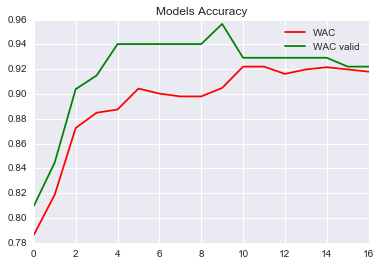

In [98]:
### Plot model accuracy
plt.clf()
unc_wac = uncert_model._monitor_outputs['wac']
unc_wac_valid = uncert_model._monitor_outputs['wac_valid']
t = np.arange(len(unc_wac))
p1 = plt.plot(t, unc_wac, 'r')
p2 = plt.plot(t, unc_wac_valid, 'g')
plt.legend((p1[0], p2[0]), ('WAC', 'WAC valid'), loc='best')
plt.title('Models Accuracy')
plt.show()

In [103]:
def generate_time_report(monitor_outputs):
    # Returns dict with percentage/amount of time spent in each section (all keys with "_time" suffix)
    report = {}
    total_time = float(sum(monitor_outputs['iter_time']))
    for k in monitor_outputs:
        if k.endswith("_time"):
            report[k] = [sum(monitor_outputs[k]), sum(monitor_outputs[k]) / total_time]
    return report

In [104]:
generate_time_report(uncert_model._monitor_outputs)

{'est_mon_time': [0.0006716251373291016, 0.0002032226773711224],
 'fit_time': [1.9592344760894775, 0.5928320035966879],
 'iter_time': [3.304872989654541, 1.0],
 'oracle_time': [0.008937358856201172, 0.002704297225393644],
 'strategy_time': [0.1831049919128418, 0.05540454731120599],
 'wac_labeled_time': [0.33414506912231445, 0.10110678085612079],
 'wac_time': [0.4857301712036133, 0.14697392992835914],
 'wac_unlabeled_time': [0.1947627067565918, 0.05893197934270702],
 'wac_valid_time': [0.1289196014404297, 0.03900894280778568]}